# Case Study 1: Consumer Loans

We have data from the performance of 72167 consumer loans in the UK. It may be possible to predict the default probability of consumer loans and investigate which variables specific to the loan is a significant predictor. In addition, we may be able to determine the value of a consumer if they have defaulted. We therefore have two tasks: 

- determine which variables have the most significant impact on default probability

- obtain a model for the value of a consumer once they have defaulted.

First we explore the data once we have imported the necessary libraries.

## Import Libraries

In [818]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import pylab 
import statistics
import datetime
import matplotlib
%matplotlib inline

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from scipy import stats
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix

C:\Users\HVAD\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [820]:
# Get Versions
print('Python Version = {}'.format(sys.version[0:31]))
print('Numpy Version = {}'.format(np.__version__))
print('Pandas Version = {}'.format(pd.__version__))
print('Matplotlib Version = {}'.format(matplotlib.__version__))
print('Seaborn Version = {}'.format(sns.__version__))
print('sklearn Version = {}'.format(sklearn.__version__))

Python Version = 3.6.4 |Anaconda custom (64-bit)
Numpy Version = 1.14.0
Pandas Version = 0.22.0
Matplotlib Version = 2.1.2
Seaborn Version = 0.8.1
sklearn Version = 0.19.1


## The Loans Dataset

First we read in the excel sheets and write to csv as a 1-time action since reading from CSV is quicker in subsequent notebook startups.

In [4]:
if((not os.path.isfile('Performance.csv')) or (not os.path.isfile('StaticData.csv'))):
    StaticData = pd.read_excel('LoansDataset.xlsx',sheet_name='Static Data')
    Performance = pd.read_excel('LoansDataset.xlsx',sheet_name='Performance',header=1)

    # Note that here, all NA values are converted to null or empty
    StaticData.to_csv('StaticData.csv',index=False)
    Performance.to_csv('Performance.csv',index=False)

In [5]:
StaticData = pd.read_csv('StaticData.csv',low_memory=False)
Performance = pd.read_csv('Performance.csv',low_memory=False)

We can see below that there are 72167 records. The LoanID is viable for use as a unique index since we see that there are 72167 unique values for this column. This also means that we can merge the StaticData dataframe with the Performance dataframe on LoanID and not generate multiple records.

In [10]:
StaticData.info()

print('\n\nThe number of unique entries for LoanID in the StaticData DataFrame is {}'.format(StaticData['LoanID'].nunique()))
print('The number of unique entries for LoanID in the Performance DataFrame is {}'.format(Performance['LoanID'].nunique()))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72167 entries, 0 to 72166
Data columns (total 20 columns):
Year                             72167 non-null int64
LoanID                           72167 non-null int64
Original Loan Size               72167 non-null float64
Origination Date                 72167 non-null object
Original Term                    72167 non-null int64
APR                              72167 non-null float64
Loan Rate                        72167 non-null float64
LTV                              72167 non-null float64
Monthly Instalment               72167 non-null float64
Type 1                           72167 non-null object
Type 2                           72167 non-null object
Borrower's Employment Status     72167 non-null object
Risk Tier                        72167 non-null object
Exposure At Default              3168 non-null float64
Further Recovery Expected Y/N    3168 non-null object
Recoveries @ 6m                  1801 non-null float64
Recoveries

Here's the distribution of loans accross years

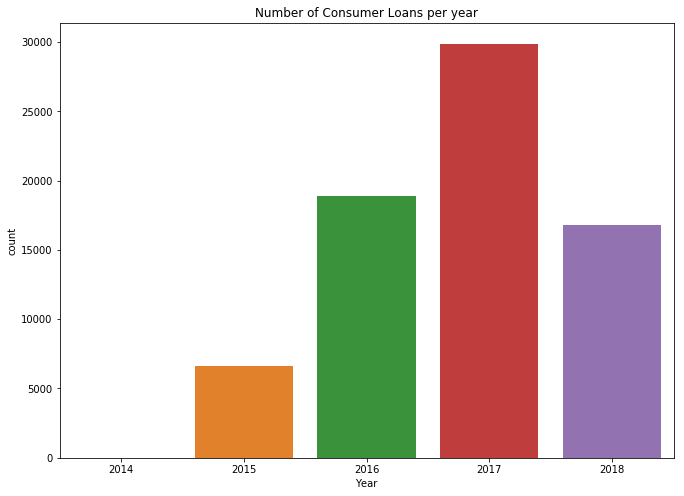

In [15]:
# Get the figure and axis handles
fig, ax = plt.subplots()

# Set the title
ax.set_title('Number of Consumer Loans per year')

# Countplot
sns.countplot(x="Year",data=StaticData)

# Set figure size
fig.set_size_inches(11, 8)

It seems that most loans are dated in 2017. Additionally, below we see that *Employed* consumers take/are given loans the most regardless of the year.

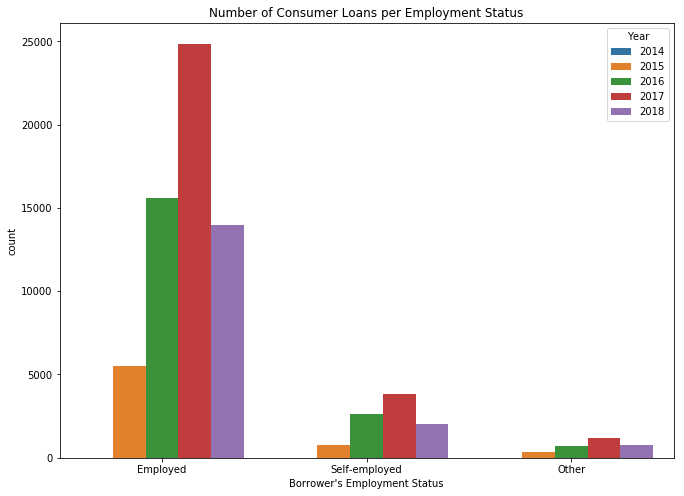

In [17]:
# Get the figure and axis handles
fig, ax = plt.subplots()

# Set the title
ax.set_title('Number of Consumer Loans per Employment Status')

# Countplot
sns.countplot(x="Borrower's Employment Status",hue='Year',data=StaticData)

# Set figure size
fig.set_size_inches(11, 8)

We merge the Performance DataFrame with the StaticData DataFrame to obtain performance information for each loan

In [18]:
# ACTION: Merge
MergedData = StaticData.merge(Performance.iloc[:,0:3],on='LoanID')

What does default within the first 24 months actually mean? We will have to give a specific definition and the definition we give here is 'All cases with default within the first 12 months is a subset of all cases with default within the first 24 months'. We can see below that there is some ambiguity in the *Status 24* column. Specifically, there are 709 cases where there has been a default within the first 12 months but we have 'NA' in the *Status 24* column.

In [19]:
len(MergedData[(MergedData['Status 12'] == 1) & (MergedData['Status 24'] != 1)])

709

We therefore create a new column called *Default 24* which caters for this. Below we see that there are no longer any cases that allow for a default within the first 12 months but 'NA' in the first 24 months. We also make sure that in cases where there is no default within 12 months, and the *Status 24* column has 'NA' that there is no default within 24 months also.

In [20]:
# ACTION: Create new Default24 column and use this in the models instead of Status 24

def default24(x):
    '''
    This function is used in the creation of the Default24 column in accordance with the definition we use here.
    x := A row of a DataFrame with x[0], x[1] the 'Status 12' and 'Status 24' columns respectively.
    The logic is: If Status 12 = 1, then Default24 = 1. If Status 12 = 0 and Status 24 = NA, then Default24 = 0,
    otherwise, Default24 = Status 24.
    '''
    if x[0] == 1:
        return 1
    elif x[0] == 0 and np.isnan(x[1]):
        return 0
    else:
        return x[1]
    


In [21]:
# Create a new column dependent on whether there has been a default within the first 12 months
MergedData['Default24'] = MergedData[['Status 12','Status 24']].apply(lambda x: default24(x),axis=1)
print('There are {} cases of ambiguity with the \'Default24\' column'.format(len(MergedData[(MergedData['Status 12'] == 1) & (MergedData['Default24'] != 1)])))

There are 0 cases of ambiguity with the 'Default24' column


We can see that in proportion to the total number of loans, there are very few that have defaulted. We plot the number of consumer loans per default category for both the 12 month and 24 months cases separately.

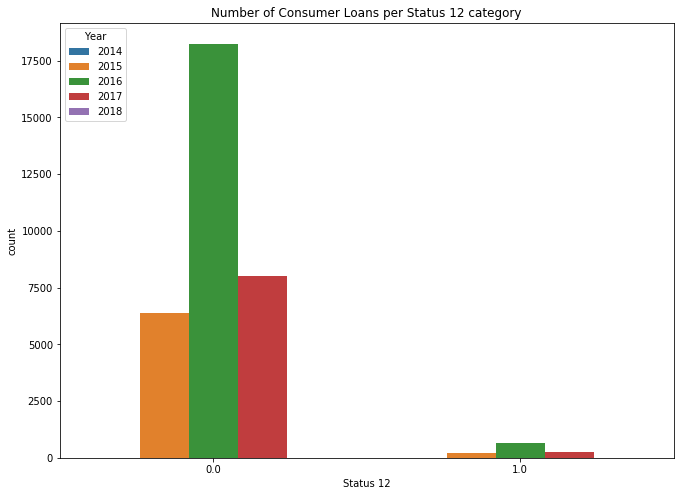

In [25]:
# Get the figure and axis handles
fig, ax = plt.subplots()

# Set the title
ax.set_title('Number of Consumer Loans per Status 12 category')

# Countplot
sns.countplot(x="Status 12",hue='Year',data=MergedData)

# Set figure size
fig.set_size_inches(11, 8)

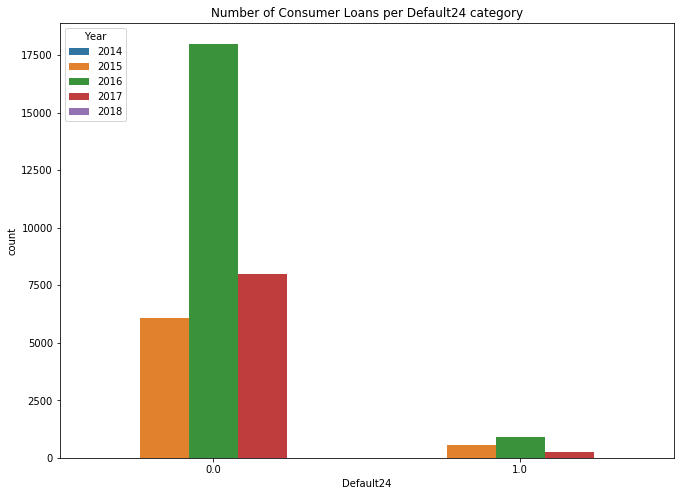

In [28]:
# Get the figure and axis handles
fig, ax = plt.subplots()

# Set the title
ax.set_title('Number of Consumer Loans per Default24 category')

# Countplot
sns.countplot(x="Default24",hue='Year',data=MergedData)

# Set figure size
fig.set_size_inches(11, 8)

There are no cases with values in the Default Status columns for the year 2018 as we see below.

In [30]:
MergedData[(MergedData['Status 12'].apply(lambda x: not np.isnan(x))) & (MergedData['Year'] == 2018)]

,Year,LoanID,Original Loan Size,Origination Date,Original Term,APR,Loan Rate,LTV,Monthly Instalment,Type 1,...,Exposure At Default,Further Recovery Expected Y/N,Recoveries @ 6m,Recoveries @ 9m,Recoveries @ 12m,Total Recovery,Prepayment Amount,Status 12,Status 24,Default24


Next, we look more closely at the probability (or proportion) of default.

#### Default Probability

It seems that except for year 2014 for which there were no defaults, the average *Loan Rate* for those that didn't default is slightly lower than for those that did default. This holds true for both the 12 month and 24 month periods. This suggests that the *Loan Rate* can give us some information as to the probability of default:

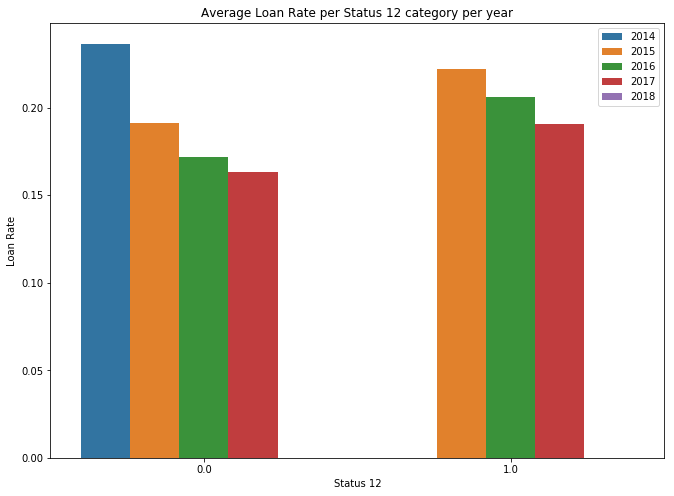

In [35]:
# ACTION: Add loan rate to the model parameters

# Get the figure and axis handles
fig, ax = plt.subplots()

# Set the title
ax.set_title('Average Loan Rate per Status 12 category per year')

# Countplot
sns.barplot(x="Status 12",y='Loan Rate',hue='Year',data=MergedData,ci=0)

# Set the legend location
ax.legend(loc=1)

# Set figure size
fig.set_size_inches(11, 8)

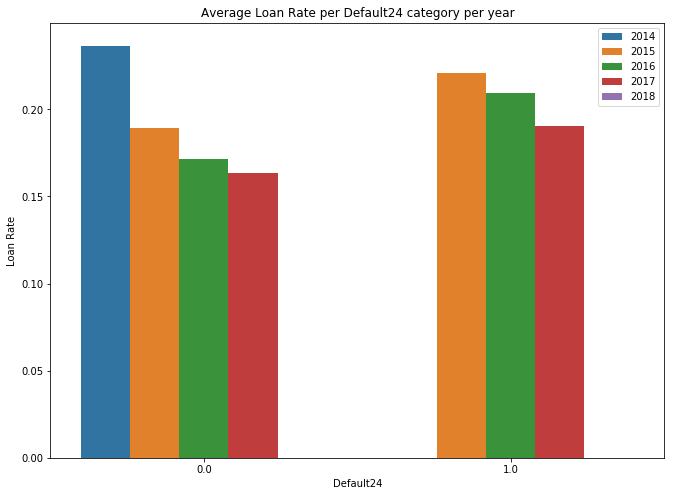

In [36]:
# Get the figure and axis handles
fig, ax = plt.subplots()

# Set the title
ax.set_title('Average Loan Rate per Default24 category per year')

# Countplot
sns.barplot(x="Default24",y='Loan Rate',hue='Year',data=MergedData,ci=0)

# Set the legend location
ax.legend(loc=1)

# Set figure size
fig.set_size_inches(11, 8)

Consumers that default have a consistently larger Original Loan Size on average each year. This may also be an indicator of default. Below, we plot the mean Original Loan Size per Default Status Category for both with 12 months and 24 months.

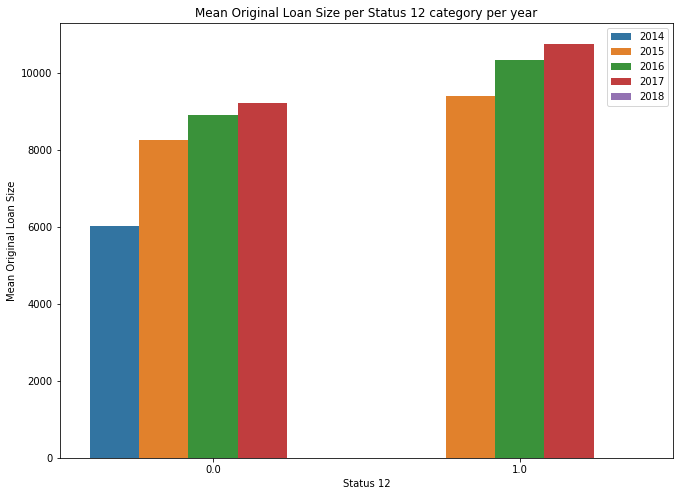

In [46]:
# ACTION: Add Original Loan Size to the model parameters

# Get the figure and axis handles
fig, ax = plt.subplots()

# Set the title
ax.set_title('Mean Original Loan Size per Status 12 category per year')

# Countplot
sns.barplot(x="Status 12",y='Original Loan Size',hue='Year',data=MergedData,ci=0)

# Set the y label
ax.set_ylabel('Mean Original Loan Size')

# Set the legend location
ax.legend(loc=1)

# Set figure size
fig.set_size_inches(11, 8)

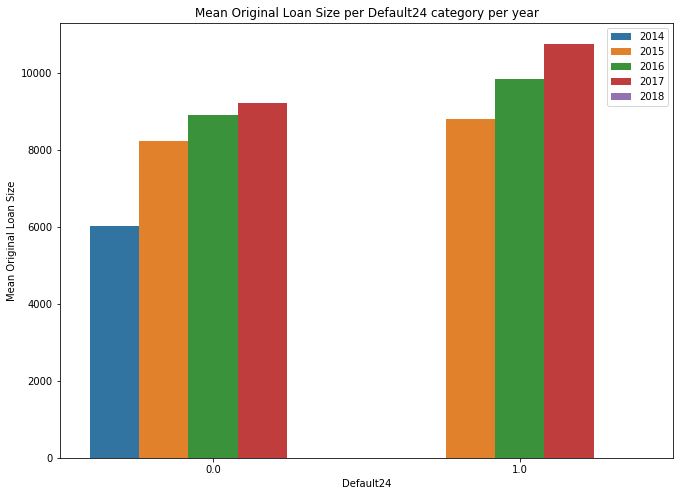

In [47]:
# Get the figure and axis handles
fig, ax = plt.subplots()

# Set the title
ax.set_title('Mean Original Loan Size per Default24 category per year')

# Countplot
sns.barplot(x="Default24",y='Original Loan Size',hue='Year',data=MergedData,ci=0)

# Set the y label
ax.set_ylabel('Mean Original Loan Size')

# Set the legend location
ax.legend(loc=1)

# Set figure size
fig.set_size_inches(11, 8)

Let's see if *Employment Status* is any indication for default. We can't just do a count plot since we know that more Employed Consumers take out loans. So we find the ratio of default in each category by grouping on *Borrower's Employment Status*. We see that whether a consumer is *Self-employed*, *Employed* or *Other* is correlated with the default probability.

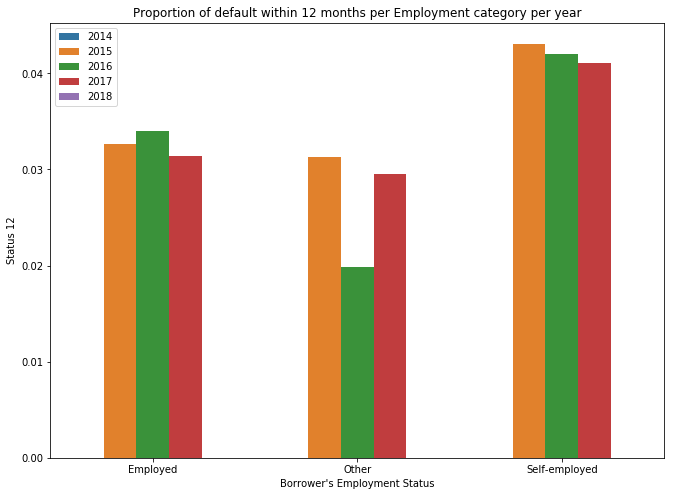

In [51]:
# ACTION: Create dummy data for Self-employed and other and add them to the model parameters
MeanDefault = MergedData[['Year', 'Status 12', 'Status 24','Default24', "Borrower's Employment Status"]].groupby(["Borrower's Employment Status",'Year']).mean().reset_index()

# Get the figure and axis handles
fig, ax = plt.subplots()

# Set the title
ax.set_title('Proportion of default within 12 months per Employment category per year')

# Countplot
sns.barplot(x="Borrower's Employment Status", y="Status 12",hue="Year",data=MeanDefault,ci=0)

# Set the y label
ax.set_ylabel('Status 12')

# Set the legend location
ax.legend(loc=0)

# Set figure size
fig.set_size_inches(11, 8)

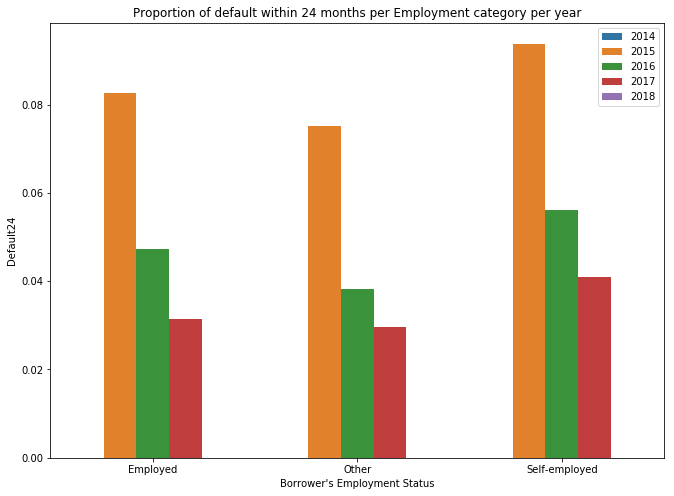

In [53]:
# Get the figure and axis handles
fig, ax = plt.subplots()

# Set the title
ax.set_title('Proportion of default within 24 months per Employment category per year')

# Countplot
sns.barplot(x="Borrower's Employment Status", y="Default24",hue="Year",data=MeanDefault,ci=0)

# Set the legend location
ax.legend(loc=1)

# Set figure size
fig.set_size_inches(11, 8)

We can see below that as the *Original Term* increases, the proportion of default also increases (although this is less pronounced for the 'Default24' Categorical variable). We can create bins of 5 and categorise in order to not have too few records in a bucket. We first create a function to categorise Original Term <= 25 as 25 and Original Term >= 70 as 70. First, wee plot the distribution of *Original Term* to get an idea of the ranges with too few observations. Then we follow with the count plots of the transformed and bucketed data.

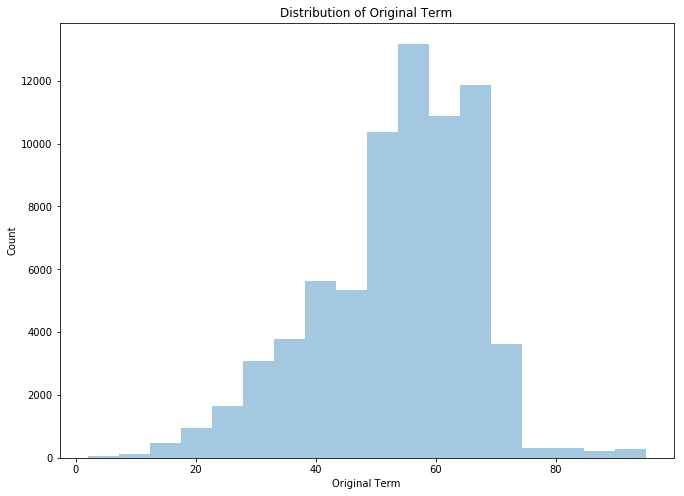

In [67]:
# Get the figure and axis handles
fig, ax = plt.subplots()

# Set the title
ax.set_title('Distribution of Original Term')

# Bins of width 5
bins = int((max(MergedData['Original Term']) - min(MergedData['Original Term']))/5)

# Set y label
ax.set_ylabel('Count')

# Countplot
sns.distplot(MergedData['Original Term'],bins=bins,kde=False)

# Set figure size
fig.set_size_inches(11, 8)

In [69]:
def getTermCategory(x):
    '''
    A function to be used to even out the number of observation within a term bucket in order to see default rates
    within each category.
    x := An element from the 'Original Term' column of the StaticData table.
    Logic: Bucket Original Term <= 25 and >= 70 into their own categories.
    '''
    if x <= 25:
        return 25
    elif x >= 70:
        return 70
    else:
        return x


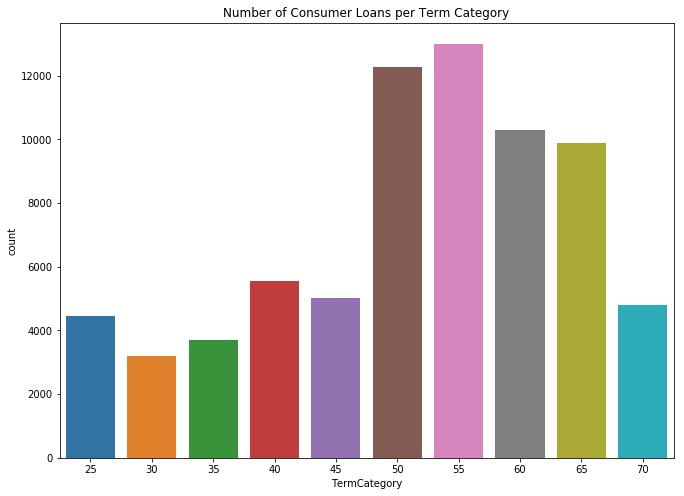

In [78]:
# ACTION: Create Original Term buckets of 5. Group up >= 75 and <=25 into their own categories. 
# Create dummy variables. Then add to the model as a parameter.

# We will create buckets of 5
x = MergedData['Original Term'].apply(lambda x: int(x/5)*5)

xdf = pd.DataFrame(x)
xdf['TermCategory'] = xdf['Original Term'].apply(lambda x: getTermCategory(x))

# Get the figure and axis handles
fig, ax = plt.subplots()

# Set the title
ax.set_title('Number of Consumer Loans per Term Category')

# Countplot
sns.countplot(xdf['TermCategory'])

# Set figure size
fig.set_size_inches(11, 8)

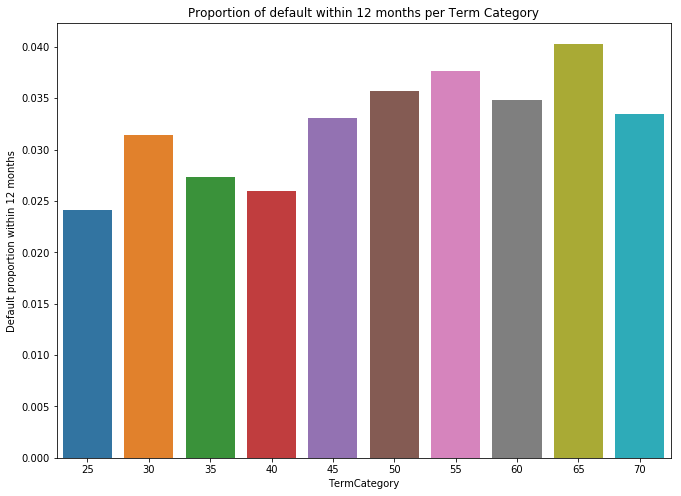

In [85]:
# Get the figure and axis handles
fig, ax = plt.subplots()

# Set the title
ax.set_title('Proportion of default within 12 months per Term Category')

# The plot
sns.barplot(x=xdf['TermCategory'], y=MergedData["Status 12"],ci=0)

# Set the y label
ax.set_ylabel('Default proportion within 12 months')

# Set figure size
fig.set_size_inches(11, 8)

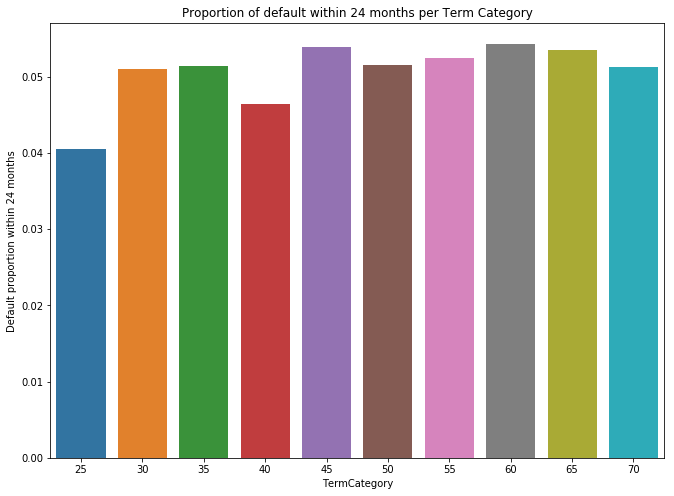

In [87]:
# Get the figure and axis handles
fig, ax = plt.subplots()

# Set the title
ax.set_title('Proportion of default within 24 months per Term Category')

# The plot
sns.barplot(x=xdf['TermCategory'], y=MergedData["Default24"],ci=0)

# Set the y label
ax.set_ylabel('Default proportion within 24 months')

# Set figure size
fig.set_size_inches(11, 8)

We can see above that as the term increases, there is a slightly higher chance of default for both 12 and 24 month defaults. Next, we investigate the relationship between APR and default. APR is often related to Loan Rate and since we saw above that the loan rate has some correlation on default it is not surprising to see a similar case for APR.

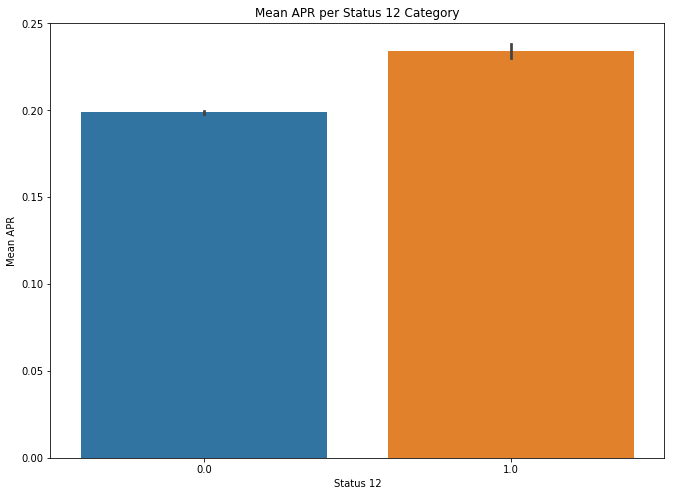

In [89]:
# Those that default have higher APR on average

# Get the figure and axis handles
fig, ax = plt.subplots()

# Set the title
ax.set_title('Mean APR per Status 12 Category')

# The plot
sns.barplot(x="Status 12", y="APR",data=MergedData)

# Set the y label
ax.set_ylabel('Mean APR')

# Set figure size
fig.set_size_inches(11, 8)

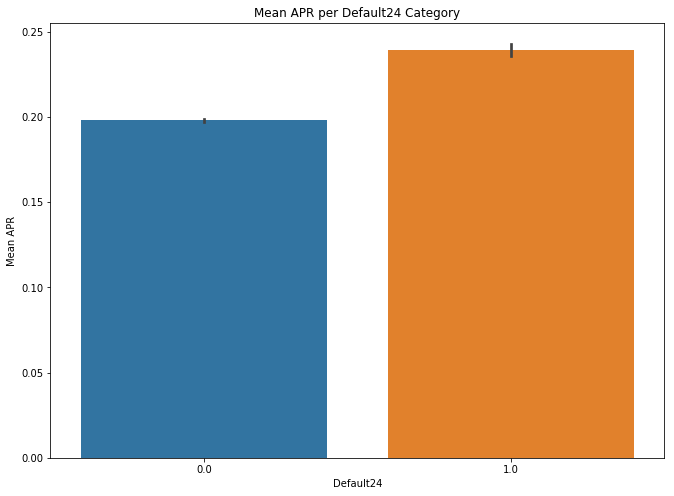

In [664]:
# Those that default have higher APR on average

# Get the figure and axis handles
fig, ax = plt.subplots()

# Set the title
ax.set_title('Mean APR per Default24 Category')

# The plot
sns.barplot(x="Default24", y="APR",data=MergedData)

# Set the y label
ax.set_ylabel('Mean APR')

# Set figure size
fig.set_size_inches(11, 8)

However, as we see below, APR is highly correlated with Loan Rate and so we will omit this variable from the models.

In [665]:
MergedData[['Loan Rate','APR']].corr()

,Loan Rate,APR
Loan Rate,1.000000,0.864978
APR,0.864978,1.000000


Tier is a good indicator since higher tiers correspond to higher proportion of default for both the 12 month and 24 month periods. We show this below for both the *Status 12* and *Default24* variables.

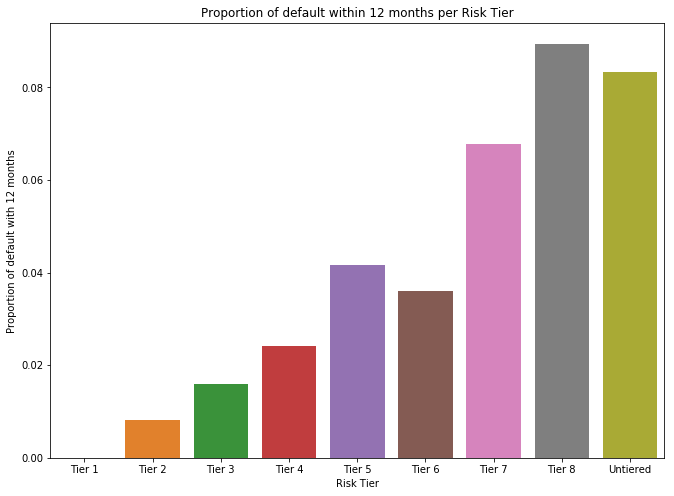

In [93]:
# ACTION: Create dummy indicators for Tier and add it to the model.

# Get the figure and axis handles
fig, ax = plt.subplots()

# Set the title
ax.set_title('Proportion of default within 12 months per Risk Tier')

# The plot
sns.barplot(x="Risk Tier", y="Status 12",data=MergedData,\
                order=['Tier 1','Tier 2','Tier 3','Tier 4','Tier 5'\
                       ,'Tier 6','Tier 7','Tier 8','Untiered'],ci=0)

# Set the y label
ax.set_ylabel('Proportion of default with 12 months')

# Set figure size
fig.set_size_inches(11, 8)

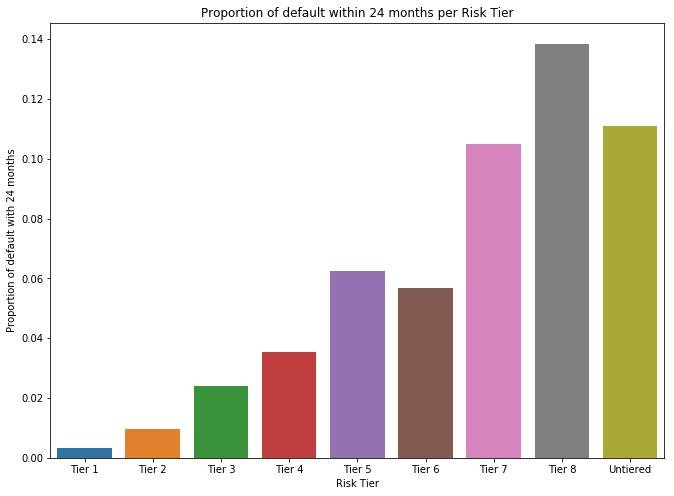

In [94]:
# Get the figure and axis handles
fig, ax = plt.subplots()

# Set the title
ax.set_title('Proportion of default within 24 months per Risk Tier')

# The plot
sns.barplot(x="Risk Tier", y="Default24",data=MergedData,\
                order=['Tier 1','Tier 2','Tier 3','Tier 4','Tier 5',\
                       'Tier 6','Tier 7','Tier 8','Untiered'],ci=0)

# Set the y label
ax.set_ylabel('Proportion of default with 24 months')

# Set figure size
fig.set_size_inches(11, 8)

We would like to see how LTV is related to the default proportion. The distribution of LTV is right skewed as we see below. We also see that smaller values of LTV have only a small representative sample. We will first bucket the LTV values and plot them against the default proportions within each bucket to see if there is a relationship.

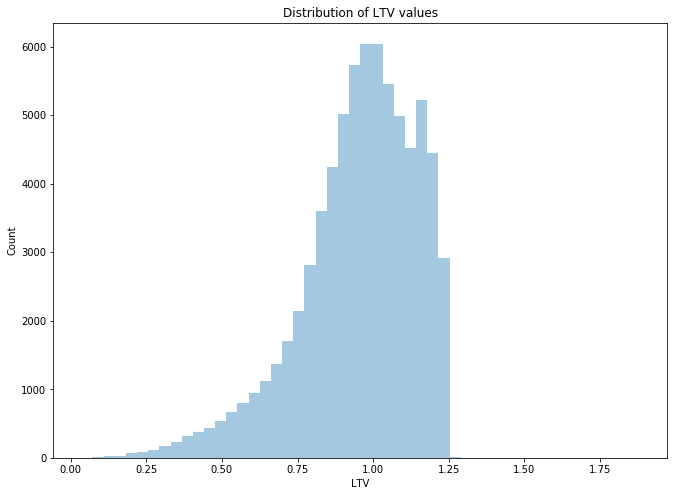

In [97]:
# Get the figure and axis handles
fig, ax = plt.subplots()

# Set the title
ax.set_title('Distribution of LTV values')

# The plot
sns.distplot(MergedData["LTV"],kde=False)

# Set the y label
ax.set_ylabel('Count')

# Set the x label
ax.set_xlabel('LTV')

# Set figure size
fig.set_size_inches(11, 8)

In [98]:
def getLTVCategory(x):
    '''
    A function to be used to bucket the LTV to even out observation within each bucket so a default proportion can be observed.
    x := An element in from the LTV column of the StaticData DataFrame.
    Logic: Bucket LTV <= 0.4 and >= 1.2 into their own buckets.
    '''
    if x <= 0.4:
        return 0.4
    elif x >= 1.2:
        return 1.2
    else:
        return round(int(x/0.1)*0.1,2)

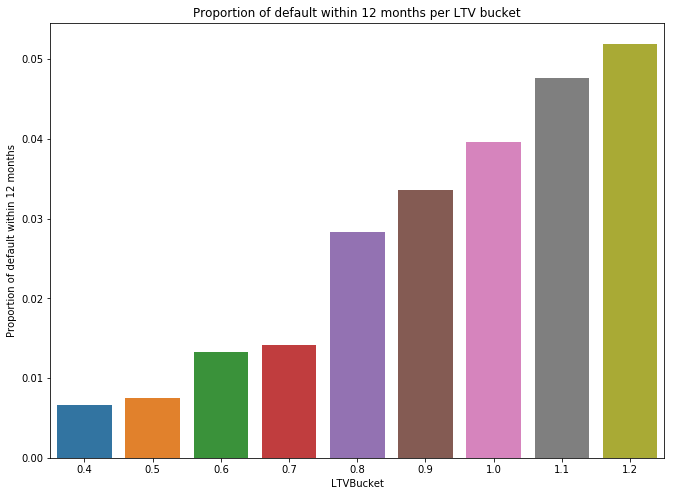

In [105]:
# ACTION: Create LTV buckets. Add this as a numerical feature to the model parameters
MergedData['LTVBucket'] = MergedData['LTV'].apply(getLTVCategory)

# Get the figure and axis handles
fig, ax = plt.subplots()

# Set the title
ax.set_title('Proportion of default within 12 months per LTV bucket')

# The plot
sns.barplot(x="LTVBucket", y="Status 12",data=MergedData,ci=0)

# Set the y label
ax.set_ylabel('Proportion of default within 12 months')

# Set figure size
fig.set_size_inches(11, 8)

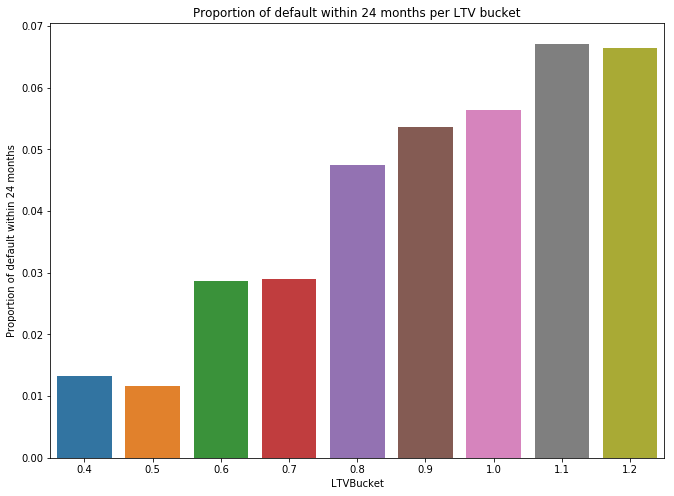

In [104]:
# Get the figure and axis handles
fig, ax = plt.subplots()

# Set the title
ax.set_title('Proportion of default within 24 months per LTV bucket')

# The plot
sns.barplot(x="LTVBucket", y="Default24",data=MergedData,ci=0)

# Set the y label
ax.set_ylabel('Proportion of default within 24 months')

# Set figure size
fig.set_size_inches(11, 8)

The *Monthly Instalment* as a percentage of the *Original Loan Size* looks to be related to an increased proportion of defaults. We first look at the distribution of Original Loan Size and bucket these values just like we did for LTV above. We then look at the relationship with default proportion via bar plots.

In [106]:
# ACTION: Create a Monthly Instalment pct column. Bucket these. Then add to the model as a parameter.

MergedData['MonthlyInstalmentpct'] = MergedData[['Original Loan Size','Monthly Instalment']]\
.apply(lambda x: x[1]*100/x[0],axis=1)

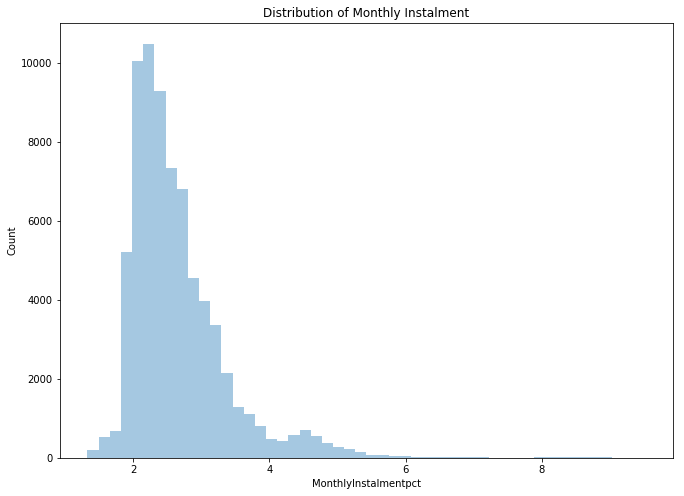

In [107]:
# Get the figure and axis handles
fig, ax = plt.subplots()

# Set the title
ax.set_title('Distribution of Monthly Instalment')

# The plot
sns.distplot(MergedData["MonthlyInstalmentpct"],kde=False)

# Set the y label
ax.set_ylabel('Count')

# Set figure size
fig.set_size_inches(11, 8)

In [111]:
def getInstalmentpctCategory(x):
    '''
    A function to be used to bucket the 'Monthly Instalment' to even out observation within each 
    bucket so a default proportion can be observed.
    x := An element in from the 'Monthly Instalment' column of the StaticData DataFrame.
    Logic: Bucket Monthly Instalment <= 1.5 and >= 4 into their own buckets.
    '''
    if x <= 1.5:
        return 1.5
    elif x >= 4:
        return 4
    else:
        return int(x/0.5)*0.5

In [112]:
# Group some buckets together
MergedData['InstalmentpctBucket'] = MergedData['MonthlyInstalmentpct'].apply(getInstalmentpctCategory)

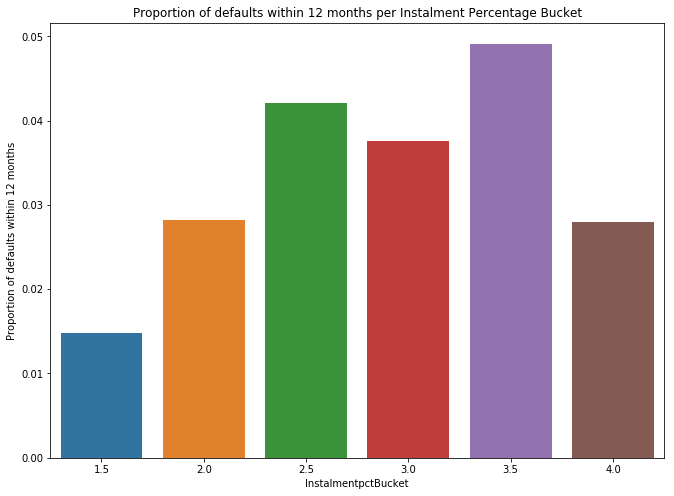

In [115]:
# Get the figure and axis handles
fig, ax = plt.subplots()

# Set the title
ax.set_title('Proportion of defaults within 12 months per Instalment Percentage Bucket')

# The plot
sns.barplot(x="InstalmentpctBucket", y="Status 12",data=MergedData,ci=0)

# Set the y label
ax.set_ylabel('Proportion of defaults within 12 months')

# Set figure size
fig.set_size_inches(11, 8)

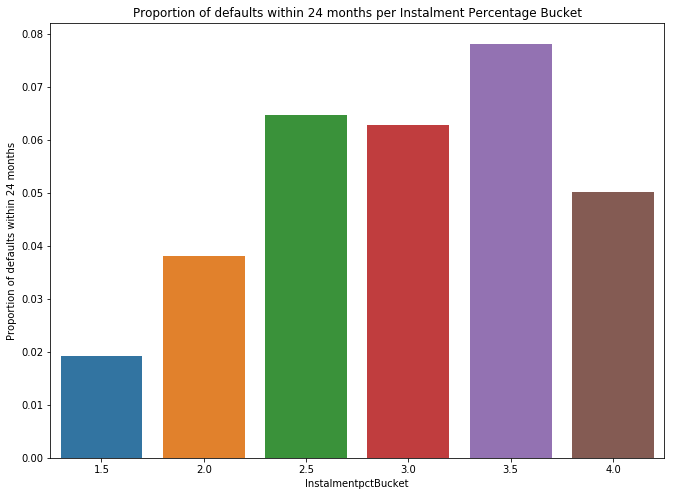

In [123]:
# Get the figure and axis handles
fig, ax = plt.subplots()

# Set the title
ax.set_title('Proportion of defaults within 24 months per Instalment Percentage Bucket')

# The plot
sns.barplot(x="InstalmentpctBucket", y="Default24",data=MergedData,ci=0)

# Set the y label
ax.set_ylabel('Proportion of defaults within 24 months')

# Set figure size
fig.set_size_inches(11, 8)

We see below that 2018 does not have any information for the default status columns and only 27% of loans in 2017 have default information. We will leave these null values out for the modelling since we'd like to preserve the prior probability of default.

In [119]:
statusNull122015 = pd.isna(MergedData[(MergedData['Year'] == 2015)]['Status 12']).sum()/len(MergedData[(MergedData['Year'] == 2015)]['Status 12'])
statusNull242015 = pd.isna(MergedData[(MergedData['Year'] == 2015)]['Default24']).sum()/len(MergedData[(MergedData['Year'] == 2015)]['Default24'])

print('{} % of the data in 2015 have non-null \'Status 12\' values'.format((1-statusNull122015)*100))
print('{} % of the data in 2015 have non-null \'Default24\' values\n'.format((1-statusNull242015)*100))



statusNull122016 = pd.isna(MergedData[(MergedData['Year'] == 2016)]['Status 12']).sum()/len(MergedData[(MergedData['Year'] == 2016)]['Status 12'])
statusNull242016 = pd.isna(MergedData[(MergedData['Year'] == 2016)]['Default24']).sum()/len(MergedData[(MergedData['Year'] == 2016)]['Default24'])

print('{} % of the data in 2016 have non-null \'Status 12\' values'.format((1-statusNull122016)*100))
print('{} % of the data in 2016 have non-null \'Default24\' values\n'.format((1-statusNull242016)*100))



statusNull122017 = pd.isna(MergedData[(MergedData['Year'] == 2017)]['Status 12']).sum()/len(MergedData[(MergedData['Year'] == 2017)]['Status 12'])
statusNull242017 = pd.isna(MergedData[(MergedData['Year'] == 2017)]['Default24']).sum()/len(MergedData[(MergedData['Year'] == 2017)]['Default24'])

print('{} % of the data in 2017 have non-null \'Status 12\' values'.format((1-statusNull122017)*100))
print('{} % of the data in 2017 have non-null \'Default24\' values\n'.format((1-statusNull242017)*100))



statusNull122018 = pd.isna(MergedData[(MergedData['Year'] == 2018)]['Status 12']).sum()/len(MergedData[(MergedData['Year'] == 2018)]['Status 12'])
statusNull242018 = pd.isna(MergedData[(MergedData['Year'] == 2018)]['Default24']).sum()/len(MergedData[(MergedData['Year'] == 2018)]['Default24'])

print('{} % of the data in 2018 have non-null \'Status 12\' values'.format((1-statusNull122018)*100))
print('{} % of the data in 2018 have non-null \'Default24\' values'.format((1-statusNull242018)*100))

100.0 % of the data in 2015 have non-null 'Status 12' values
100.0 % of the data in 2015 have non-null 'Default24' values

100.0 % of the data in 2016 have non-null 'Status 12' values
100.0 % of the data in 2016 have non-null 'Default24' values

27.69503664781284 % of the data in 2017 have non-null 'Status 12' values
27.69503664781284 % of the data in 2017 have non-null 'Default24' values

0.0 % of the data in 2018 have non-null 'Status 12' values
0.0 % of the data in 2018 have non-null 'Default24' values


We have investigated some possible variables for our models later in the project which may be related to default probability. We can now turn our attention to the amount that can be recovered from a consumer in the case that default is a concern.

#### Modelling Value as a function of Loan Rate


We may be able to model the $\textbf{Value=Original Loan Size} \times \textbf{Total Recovery}$ as a function of *Loan Rate* and *Original Term*. Here we are only interested in the consumers that have defaulted because we want to obtain a model for those that have defaulted. We see below that *Value* looks to be a non-linear function of *Loan Rate*. We get a more linear scatter plot when we use $\textbf{Loan Rate}^2$.

In [668]:
# ACTION: Create a Value column. Add the parameters Loan Rate and Original Term to a Linear Regression model

MergedData['Value'] = MergedData['Original Loan Size']*MergedData['Total Recovery']
MergedDataDefaulted12 = MergedData[(MergedData['Status 12'] == 1) & (pd.isna(MergedData['Exposure At Default']).apply(lambda x: not x))]
MergedDataDefaulted24 = MergedData[(MergedData['Default24'] == 1) & (pd.isna(MergedData['Exposure At Default']).apply(lambda x: not x))]

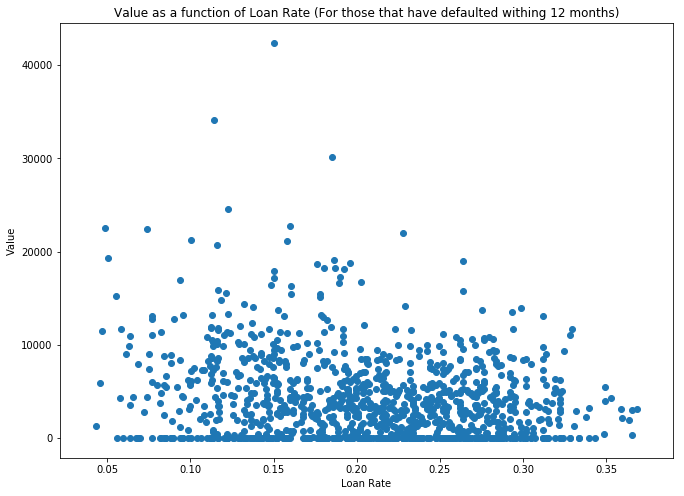

In [669]:
# Let's obtain a relationship with Loan Rate

fig, ax = plt.subplots()

fig.set_size_inches(11, 8)

plt.scatter(x=((MergedDataDefaulted12['Loan Rate'])),y=MergedDataDefaulted12['Value'])
ax.set_ylabel('Value')
ax.set_xlabel('Loan Rate')
title = ax.set_title('Value as a function of Loan Rate (For those that have defaulted withing 12 months)')

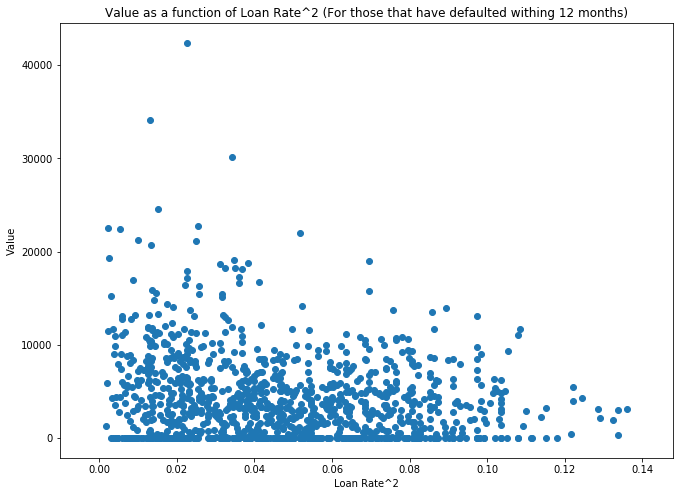

In [670]:
fig, ax = plt.subplots()

fig.set_size_inches(11, 8)

plt.scatter(x=((MergedDataDefaulted12['Loan Rate']**2)),y=MergedDataDefaulted12['Value'])
ax.set_ylabel('Value')
ax.set_xlabel('Loan Rate^2')
title = ax.set_title('Value as a function of Loan Rate^2 (For those that have defaulted withing 12 months)')

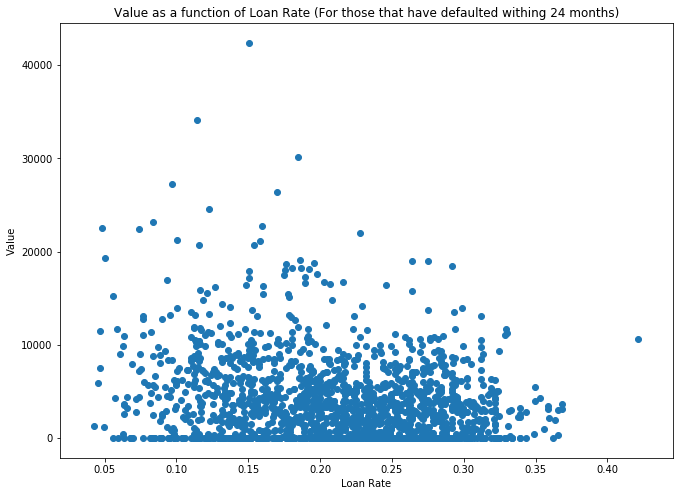

In [671]:
fig, ax = plt.subplots()

fig.set_size_inches(11, 8)

plt.scatter(x=((MergedDataDefaulted24['Loan Rate'])),y=MergedDataDefaulted24['Value'])

ax.set_ylabel('Value')
ax.set_xlabel('Loan Rate')
title = ax.set_title('Value as a function of Loan Rate (For those that have defaulted withing 24 months)')

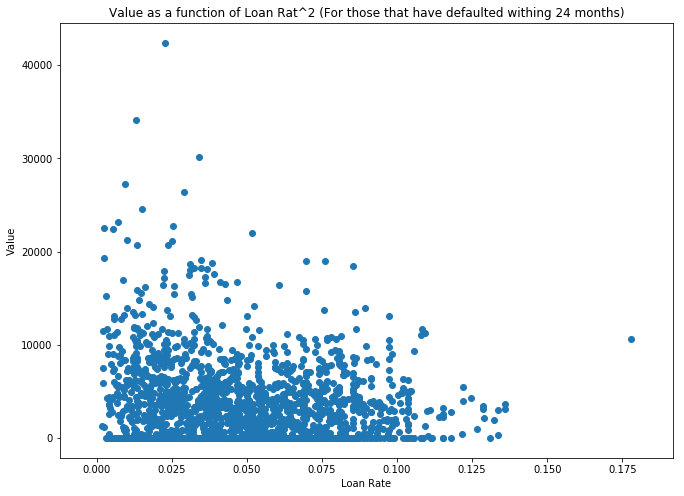

In [672]:
fig, ax = plt.subplots()

fig.set_size_inches(11, 8)

plt.scatter(x=((MergedDataDefaulted24['Loan Rate']**2)),y=MergedDataDefaulted24['Value'])

ax.set_ylabel('Value')
ax.set_xlabel('Loan Rate')
title = ax.set_title('Value as a function of Loan Rat^2 (For those that have defaulted withing 24 months)')

#### Transformation and Cleaning

Our transform and clean function should have the following actions from our analysis above:

0- ACTION: Merge

1- ACTION: Create new Default24 column and use this instead in the models

2- ACTION: Create dummy data for Self-employed

3- ACTION: Create Original Term buckets of 5. Group up >= 75 and <=15 into their own categories

4- ACTION: Create dummy indicators for Tier

5- ACTION: Create LTV buckets

6- ACTION: Create a Monthly Instalment pct column and bucket them

7- ACTION: Create an Value column

8- ACTION: Create Loan Rate^2 and Loan Rate*OriginalTerm Columns

The Model should have the following parameters:

1- ACTION: Add loan rate to the model parameters

2- ACTION: Add Original Loan Size to the model parameters

3- ACTION: Add dummy data for Employment Status to the model parameters

4- ACTION: Add Term Buckets to model parameters

5- ACTION: Add dummy data for Term to the model

6- ACTION: Add LTV buckets as a numerical feature to the model parameters

7- ACTION: Add the bucketed Monthly Instalment pct buckets to the model as a parameter

8- ACTION: Add the parameters Loan Rate^2 and Original Term to a Linear Regression model with both mixed effect (synergy effect) and separately in order to model ExposureRatio

In [743]:
def TransformMergeAndCleanData(df,df2):
    '''
    A function used to merge, transform and clean the dataframes according to the above 'ACTIONS' in the analysis. 
    df := The StaticData dataframe
    df2 := The Performance dataframe
    '''
    #0- Merge the two DataFrames
    df_out = df.merge(df2.iloc[:,0:3],on='LoanID')
    
    #1- Create new Default24 column and use this instead in the models
    df_out['Default24'] = df_out[['Status 12','Status 24']].apply(lambda x: default24(x),axis=1)
    
    # Convert the Origination Date to date object
    df_out['OriginationDateFormatted'] = df_out['Origination Date'].apply(lambda x: datetime.datetime.strptime(x.replace('-',''), "%Y%m%d").date())
    
    #2- Employment Status is either Employed, Unemployed or other. Create a series which has entries 0 and 1 specifying whether it's one or the other
    Employment = pd.get_dummies(df_out['Borrower\'s Employment Status'],drop_first=True)
    
    #3- We will create buckets of 5 for Original Term
    x = df_out['Original Term'].apply(lambda x: int(x/5)*5)
    xdf = pd.DataFrame(x)
    OriginalTermBucket = xdf['Original Term'].apply(lambda x: getTermCategory(x))
    OriginalTermBucket.name='OriginalTermBucket'
    
    #4- Create dummy indicators for Tier
    RiskTier = pd.get_dummies(df_out['Risk Tier'],drop_first=True)
    
    #5- Create LTV buckets
    LTVBucket = df_out['LTV'].apply(getLTVCategory)
    LTVBucket.name = 'LTVBucket'
    
    #6- Create a Monthly Instalment pct column and bucket them
    df_out['MonthlyInstalmentpct'] = df_out[['Original Loan Size','Monthly Instalment']].apply(lambda x: x[1]*100/x[0],axis=1)
    df_out['InstalmentpctBucket'] = df_out['MonthlyInstalmentpct'].apply(getInstalmentpctCategory)
    
    #7- Create an ExposureRatio column
    df_out['Value'] = df_out[['Original Loan Size','Total Recovery']].apply(lambda x: x[1]*x[0],axis=1)
    
    #8- Create APR^2 and APR*OriginalTerm Columns
    df_out['LoanRate2'] = df_out['Loan Rate']**2
    df_out['LoanRate2OriginalTerm'] = df_out['LoanRate2']*df_out['Original Term']
    df_out['LoanRateOriginalTerm'] = df_out['Loan Rate']*df_out['Original Term']
    
    Type1 = pd.get_dummies(df['Type 1'],drop_first=True)

    #Concat the series to the data frame
    df_out = pd.concat([df_out,Employment,OriginalTermBucket,RiskTier,LTVBucket,Type1],axis=1)
    
    # Remove records which have null Status 12 and Default24 entries separately
    return df_out[pd.isna(df_out['Status 12']).apply(lambda x: not x)], df_out[pd.isna(df_out['Default24']).apply(lambda x: not x)], df_out

In [744]:
df_final12,df_final24,fullDataSet = TransformMergeAndCleanData(StaticData,Performance)

## Regression

In this section we apply a logistic regression model to the parameters chosen above for the response variables 'Status 12' and 'Default24' separately. Once this is done, we will apply a linear regression model to predict the value of a consumer loan once default is expected. We will then put these two models together to develop a model for predicting the revenue of a consumer as a function of Loan Rate.

#### Logistic Regression

We've seen above that the following metrics may be related to an increase in default probability

1- ACTION: Add loan rate to the model parameters

2- ACTION: Add Original Loan Size to the model parameters

3- ACTION: Add dummy data for Employment Status to the model parameters

4- ACTION: Add Term Buckets to model parameters

5- ACTION: Add dummy data for Risk Tier to the model

6- ACTION: Add LTV buckets as a numerical feature to the model parameters

7- ACTION: Add the bucketed Monthly Instalment pct buckets to the model as a parameter

Below, we set the parameters we are interested in when fitting the logistic regression model.

In [676]:
logisticParams = ['Loan Rate','Original Loan Size',\
                              'Tier 2','Tier 3','Tier 4','Tier 5', 'Tier 6', 'Tier 7', 'Tier 8','Untiered',\
                             'Self-employed','Other','OriginalTermBucket','LTVBucket','MonthlyInstalmentpct']

Here we look at the logistic regression performed using the above selected parameters:

In [678]:
# Select the parameters
X = df_final12.reset_index()[logisticParams]
# Select the response variable
y = df_final12.reset_index()['Status 12']

# Apply the logistic regression model from statsmodels
#X = sm.add_constant(X)
model = sm.Logit(y, X)
logistic12 = model.fit()
print(logistic12.summary2())

Optimization terminated successfully.
         Current function value: 0.142770
         Iterations 9
                           Results: Logit
Model:                 Logit             No. Iterations:    9.0000   
Dependent Variable:    Status 12         Pseudo R-squared:  0.036    
Date:                  2018-10-14 23:43  AIC:               9681.8017
No. Observations:      33802             BIC:               9808.2259
Df Model:              14                Log-Likelihood:    -4825.9  
Df Residuals:          33787             LL-Null:           -5008.0  
Converged:             1.0000            Scale:             1.0000   
---------------------------------------------------------------------
                      Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
---------------------------------------------------------------------
Loan Rate             6.1639   0.6946   8.8738 0.0000  4.8025  7.5254
Original Loan Size    0.0000   0.0000   7.6096 0.0000  0.0000  0.0001
Tier 2          

In [679]:
# Select the parameters
X = df_final24.reset_index()[logisticParams]

# Select the response variable
y = df_final24.reset_index()['Default24']

# Apply the logistic regression model from statsmodels
model = sm.Logit(y, X)
logistic24 = model.fit()
print(logistic24.summary2())

Optimization terminated successfully.
         Current function value: 0.193461
         Iterations 9
                           Results: Logit
Model:                Logit             No. Iterations:    9.0000    
Dependent Variable:   Default24         Pseudo R-squared:  0.043     
Date:                 2018-10-14 23:43  AIC:               13108.7122
No. Observations:     33802             BIC:               13235.1363
Df Model:             14                Log-Likelihood:    -6539.4   
Df Residuals:         33787             LL-Null:           -6836.0   
Converged:            1.0000            Scale:             1.0000    
---------------------------------------------------------------------
                      Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
---------------------------------------------------------------------
Loan Rate             6.9268   0.5780  11.9834 0.0000  5.7939  8.0597
Original Loan Size    0.0000   0.0000   6.9858 0.0000  0.0000  0.0000
Tier 2          

In the above summaries, we see that all parameters are statistically significant. Below, we will be running the sklearn version of the logistic regression model.

In [680]:
# Select the parameters
X = df_final12.reset_index()[logisticParams]

# Select the response variable
y = df_final12.reset_index()['Status 12']

Fit the Logistic Regression model

In [681]:
lr12 = LogisticRegression(fit_intercept=True)
lr12.fit(X,y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

At this point we can use the predictions from the fitted model to get the probability distribution of the test data set. We see that the probability distribution of the test dataset is left skewed. This probability distribution is for the probability of default within 12 months and as expected, defaulting is a rare event.

The mean of this distribution is 0.03551
The median of this distribution is 0.033
The IQR of this distribution is 0.018


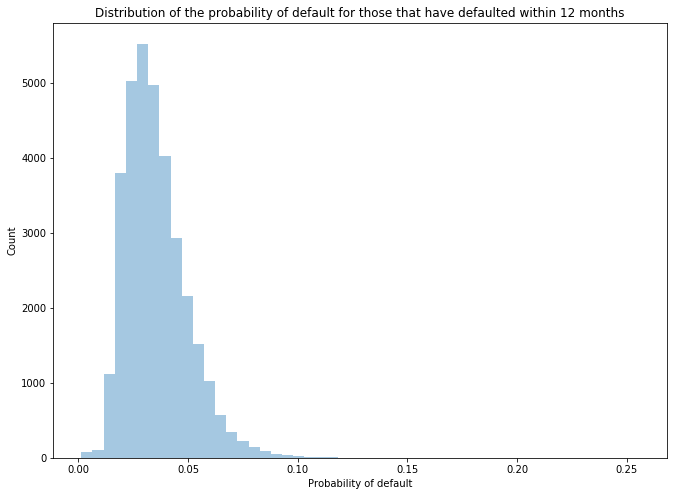

In [690]:
# Probability distribution of default for the dataset


fig, ax = plt.subplots()

fig.set_size_inches(11, 8)

sns.distplot(lr12.predict_proba(X)[:,1],kde=False)
ax.set_xlabel('Probability of default')
ax.set_ylabel('Count')
title = ax.set_title('Distribution of the probability of default for those that have defaulted within 12 months')


print('The mean of this distribution is {}'.format(round(np.mean(lr12.predict_proba(X)[:,1]),5)))

a = list(map(lambda x: round(x,3),lr12.predict_proba(X)[:,1]))
print('The median of this distribution is {}'.format(round(statistics.median(a),5)))

print('The IQR of this distribution is {}'.format(round(stats.iqr(a,rng=(25,75)),5)))

We can then calculate the default probability of the consumers with the following profiles (person1 has in fact defaulted within the 12 month period but person2 hasn't). The main differences between these two consumers is the Tier and Loan Rate. Consumer1 is in Tier 5 whereas consumer2 is in Tier 3.

In [691]:
person1 = df_final12[logisticParams].iloc[42,0:]

person2 = df_final12[logisticParams].iloc[38,0:]

In [692]:
print('Consumer1\n\n',person1,'\n\n','Consumer2\n\n',person2)


Consumer1

 Loan Rate                  0.173690
Original Loan Size      2441.177116
Tier 2                     0.000000
Tier 3                     0.000000
Tier 4                     0.000000
Tier 5                     1.000000
Tier 6                     0.000000
Tier 7                     0.000000
Tier 8                     0.000000
Untiered                   0.000000
Self-employed              0.000000
Other                      0.000000
OriginalTermBucket        35.000000
LTVBucket                  1.000000
MonthlyInstalmentpct       3.586794
Name: 43, dtype: float64 

 Consumer2

 Loan Rate                  0.076448
Original Loan Size      2528.296369
Tier 2                     0.000000
Tier 3                     1.000000
Tier 4                     0.000000
Tier 5                     0.000000
Tier 6                     0.000000
Tier 7                     0.000000
Tier 8                     0.000000
Untiered                   0.000000
Self-employed              0.000000
Other       

The above fitted logistic regression model has the following form:

$$logOdds = \ln (\frac{P(D)}{1-P(D)}) = \beta_0 + \beta_1 X_1 + ... + \beta_n X_n$$

In this model, the coefficient of Loan Rate and Loan Rate^2 is 0.09 and 0.04 respectively. This means that increasing the loan rate is correlated with an increase in the probability of default. Here, we calculate the probability of default from the logistic regression. By taking the exponential of both sides of this equation we can retrieve the probability of default (D):

$$P(D) = \frac{\exp(\beta_0 + \beta_1 X_1 + ... + \beta_n X_n)}{1+\exp(\beta_0 + \beta_1 X_1 + ... + \beta_n X_n)}$$

Programmatically, this is as follows:

In [693]:
logprob = lr12.intercept_[0]
for i in range(0,len(logisticParams)):
    logprob += lr12.coef_[0][i]*person1[i]
print('Person1 has a default probability of {}'.format((math.e**logprob)/(1+math.e**logprob)))

logprob = lr12.intercept_[0]
for i in range(0,len(logisticParams)):
    logprob += lr12.coef_[0][i]*person2[i]
print('Person2 has a default probability of {}'.format((math.e**logprob)/(1+math.e**logprob)))

Person1 has a default probability of 0.0374750850615914
Person2 has a default probability of 0.015097223969645582


In order to verify that this is in fact what the sklearn Logistic Regression classifier is doing, we can utilise the *predict_proba* method of the *Logistic Regression* object in order to get these values as well, verifying our results:

In [694]:
person1 = person1.values.reshape(1,-1)
person2 = person2.values.reshape(1,-1)

In [695]:
print('Default probability of Consumer1 = {}'.format(lr12.predict_proba(person1)[0][1]))
print('Default probability of Consumer2 = {}'.format(lr12.predict_proba(person2)[0][1]))

Default probability of Consumer1 = 0.0374750850615914
Default probability of Consumer2 = 0.01509722396964558


We do the same for the probability of default within the first 24 months

The mean of this distribution is 0.05258
The median of this distribution is 0.049
The IQR of this distribution is 0.039
Default probability of Consumer1 = 0.06142
Default probability of Consumer2 = 0.01681


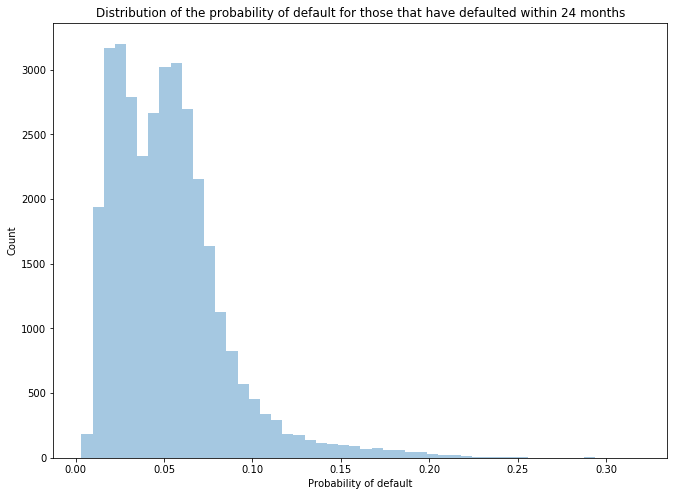

In [702]:
y = df_final24.reset_index()['Default24']
lr24 = LogisticRegression(fit_intercept=True)
lr24.fit(X,y)

# Probability distribution of default for the dataset
fig, ax = plt.subplots()

fig.set_size_inches(11, 8)

sns.distplot(lr24.predict_proba(X)[:,1],kde=False)
ax.set_xlabel('Probability of default')
ax.set_ylabel('Count')
title = ax.set_title('Distribution of the probability of default for those that have defaulted within 24 months')

print('The mean of this distribution is {}'.format(round(np.mean(lr24.predict_proba(X)[:,1]),5)))

a = list(map(lambda x: round(x,3),lr24.predict_proba(X)[:,1]))
print('The median of this distribution is {}'.format(round(statistics.median(a),5)))

print('The IQR of this distribution is {}'.format(round(stats.iqr(a,rng=(25,75)),5)))

print('Default probability of Consumer1 = {}'.format(round(lr24.predict_proba(person1)[0][1],5)))
print('Default probability of Consumer2 = {}'.format(round(lr24.predict_proba(person2)[0][1],5)))

These probabilities puts Consumer1 in to the riskier part of the distribution (i.e. a riskier consumer within the population) and Consumer2 into the safer consumer (i.e. less then median of the distribution). As expected, the probability of default within the first 24 months is greater than that for the first 12 months.

This is how we interpret the above probabilities given the definitions of the transformed columns:

$$D_{24} \cup D_{12} = D_{24}$$

$$D_{24} \cap D_{12} = D_{12}$$

$$D_{24} \cap D_{12}^c = D_{24} / D_{12}$$

$$D_{24} = \{D_{24} \cap D_{12}^c\} \cup \{ D_{24} \cap D_{12} \}$$

The sets $\{D_{24} \cap D_{12}^c\}$ and $ \{ D_{24} \cap D_{12} \}$ partition the universal set and since $D_{12} \subseteq D_{24}$ we have $ \{D_{24} \cap D_{12}^c\} = \{D_{24} / D_{12}\} $ and $ \{ D_{24} \cap D_{12} \} = D_{12}$

So,

$$P(D_{24}) = P(D_{24}/D_{12}) + P(D_{12}) \implies P(D_{24}/D_{12}) = P(D_{24}) - P(D_{12})$$

We will need this result when we want to calculate the value (how much we have salvaged) of a consumer loan based on how much recovery a consumer has achieved given that they have defaulted.

Now let's model the *Value* from all those that have defaulted.

#### Linear Regression

Value, as defined earlier, is *Original Loan Size* scaled by *Total Recovery*, so that a consumer with Original Loan Size 10000GBP and a Total Recovery of 50% has a value of 5000GBP. Once we subtract from this the total amount loaned, the revenue is negative for this consumer.

First we will define the linear parameters to be used when fitting the linear model. We then see if the variables used are statistically significant. Finally, we fit the sklearn linear regression model and predict the value of a consumer.

In [806]:
linearParams = ['LoanRate2','LoanRateOriginalTerm','LoanRate2OriginalTerm']

In [807]:
temp = df_final12[pd.isna(df_final12['Exposure At Default']).apply(lambda x: not x)].\
reset_index()[['Loan Rate','LoanRate2','Original Term','LoanRate2OriginalTerm','LoanRateOriginalTerm','Value','Tier 2','Tier 3',\
               'Tier 4','Tier 5', 'Tier 6', 'Tier 7', 'Tier 8','Untiered','OriginalTermBucket','Total Recovery','Self-employed','Other','Original Loan Size','Prepayment Amount']]

# The explanatory variables
X = temp[linearParams]

# The response variable
y = temp['Value']

# Add a Constant
X_new = sm.add_constant(X)

# Fit the logistic regression model
est = sm.OLS(y, X_new)
est2 = est.fit()

# Get a summary
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                  Value   R-squared:                       0.033
Model:                            OLS   Adj. R-squared:                  0.032
Method:                 Least Squares   F-statistic:                     31.29
Date:                Mon, 15 Oct 2018   Prob (F-statistic):           7.02e-20
Time:                        00:20:07   Log-Likelihood:                -26692.
No. Observations:                2733   AIC:                         5.339e+04
Df Residuals:                    2729   BIC:                         5.342e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  3585.57

For the linear regression model above, we can see that all parameters are statistically significant.

In [813]:
temp = df_final12[pd.isna(df_final12['Exposure At Default']).apply(lambda x: not x)].\
reset_index()

X = temp[linearParams]
y = temp['Value']

lm = LinearRegression()
lm.fit(X,y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

We now have the following equation for Value

In [827]:
print('Value = {} + {}* LR**2 + {}* LR * OT + {}* LR*2 * OT'.format(lm.intercept_,lm.coef_[0],lm.coef_[1],lm.coef_[2]))

Value = 3585.574940101065 + -39073.164730306715* LR**2 + 171.5044269061883* LR * OT + -38.59982148323444* LR*2 * OT


We can obtain predictions and assess the residuals plots

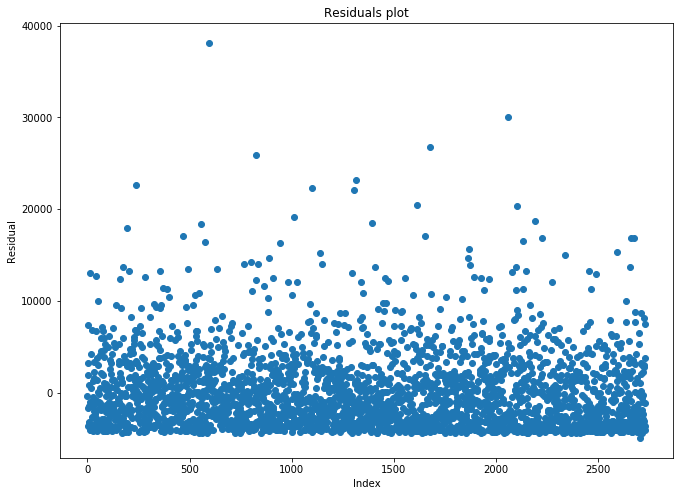

In [828]:
# Obtain predictions
predictions = lm.predict(X)

# Obtain the residuals
residuals = y - predictions

# Get the figure and axis handles
fig, ax = plt.subplots()

# Set the figure size
fig.set_size_inches(11, 8)

# The plot
plt.scatter(np.arange(0,len(residuals)),residuals)
ax.set_xlabel('Index')
ax.set_ylabel('Residual')
title = ax.set_title('Residuals plot')

We now perform a qq-plot to assess normality of the residuals

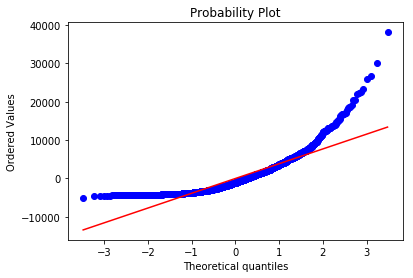

In [829]:
stats.probplot(residuals, dist="norm", plot=pylab)
pylab.show()

Here we have obtained the following equation relating Loan Rate (LR), Original Term (OT), Original Loan Size (OS) and Total Recovery (TR):

$$\text{Value} = OS \times TR = 3585.574940101065 - 39073.164730306715 \times LR^2 + 171.5044269061883 \times LR \times OT + -38.59982148323444 \times LR^2 \times OT$$

## Going Further

We might like to know how risky it is in a monetary sense to embark on a loan arrangement with a counterparty which has a certain default probability. In order to come to a conclusion, we can factor in the amount that is at risk (Original Loan Size := OLS), the default risk ($P(D_{12})$), the Original Term (OT), the Loan rate (LR) offered (though this should be a function of the risk itself but here we take it as a given) and the Total Recovery percentage (TR). 

i.e. we want to calculate the Value given that this person defaults multiplied by the probability of this person defaulting. This is Expected Value (EV):

$$EV = P(D_{12}|\theta,OLS,OT,LR)*(Value | D_{12}) + P(D_{12}^c | \theta,OLS,OT,LR) * (Value | D_{12}^c)$$
$$ = P(D_{12}|\theta,OLS,OT,LR)*(Value | D_{12}) + (1 - P(D_{12} | \theta,OLS,OT,LR)) * (OLS*LR)$$

In the above equation, $P(D_{12})$ is the default probability within 12 months, $P(D_{12}^c)=1-P(D_{12})$, and $\theta$ represents all the other variables we have used in our model to predict default probability. 

Even though OT, LR and OLS are expected to be related variables, below we can fix a value for OT and OLS and see what we can expect the shape of the EV curve to look like:

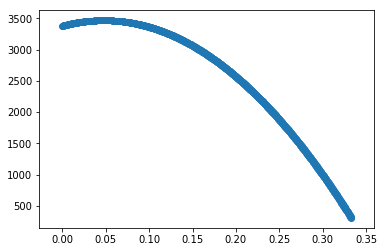

In [834]:
OT = 50
OLS = 5000

# Let LR range from 0 to 1000
LR = np.arange(0,1000)*(1/3000)

# We use our linear regression fitted values
Value = 3585.574940101065 -39073.164730306715* LR**2 + 171.5044269061883* LR * OT -38.59982148323444* LR**2 * OT

# This is the default probability within 12 months (i.e. an exponential function)
a = lr12.intercept_ + lr12.coef_[0][0] * LR + lr12.coef_[0][13] * OT
ProbDefault12 = np.array(list(map(lambda x: math.exp(x)/(1+math.exp(x)),a)))

# The total value is then the an function of default and the value given default
totValue = (1-ProbDefault12)*OLS*LR + ProbDefault12*(Value - OLS*LR)

plt.scatter(x=LR,y=totValue)

In this case, we may offer a loan rate of around 0.05 (5%) for this person.

Using the models we have derived, we can come up with an offer for Person1 and Person2:

In [835]:
person1 = df_final12[logisticParams].iloc[42,0:]

person2 = df_final12[logisticParams].iloc[38,0:]

print('Consumer1\n',person1,'\n\n','Consumer2\n',person2)



Consumer1
 Loan Rate                  0.173690
Original Loan Size      2441.177116
Tier 2                     0.000000
Tier 3                     0.000000
Tier 4                     0.000000
Tier 5                     1.000000
Tier 6                     0.000000
Tier 7                     0.000000
Tier 8                     0.000000
Untiered                   0.000000
Self-employed              0.000000
Other                      0.000000
OriginalTermBucket        35.000000
LTVBucket                  1.000000
MonthlyInstalmentpct       3.586794
Name: 43, dtype: float64 

 Consumer2
 Loan Rate                  0.076448
Original Loan Size      2528.296369
Tier 2                     0.000000
Tier 3                     1.000000
Tier 4                     0.000000
Tier 5                     0.000000
Tier 6                     0.000000
Tier 7                     0.000000
Tier 8                     0.000000
Untiered                   0.000000
Self-employed              0.000000
Other         

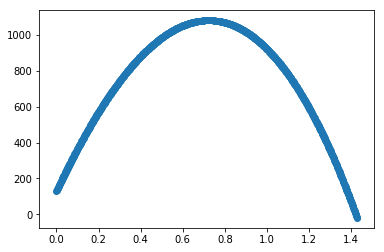

In [840]:
# Let LR range from 0 to 1000
LR = np.arange(0,1000)*(1/700)

# This list will be used to create many consumers identical to person1 but with varying Loan Rate
DummyConsumers = []

# Create the dummy consumers
for i in range(0,len(LR)):
    persontemp = []
    persontemp.append(LR[i])
    for j in range(1,len(logisticParams)):
        persontemp.append(person1[j])
    DummyConsumers.append(persontemp)

# Probability of default within 12 months of person1 as a function of loan rate
prob1 = lr12.predict_proba(DummyConsumers)[:,1]

# The OLS for this consumer
OLS = person1['Original Loan Size']

# The OT for this consumer
OT = person1['OriginalTermBucket']

# We use our linear regression fitted values
Value = 3585.574940101065 -39073.164730306715* LR**2 + 171.5044269061883* LR * OT -38.59982148323444* LR**2 * OT

# The expected loss cannot be positive, value has to be less than OLS*LR
ExpectedLoss = prob1*(Value - OLS*LR)
map(lambda x: 0 if x > 0 else x,ExpectedLoss)

# The total value is then a function of default and the value given default
totValue = (1-prob1)*OLS*LR + ExpectedLoss

plt.scatter(x=LR,y=totValue)

The best Loan Rate for person1 is therefore around 0.75. However, this consumer was given a Loan Rate of 0.17. Next we assess person2 in a similar manner.

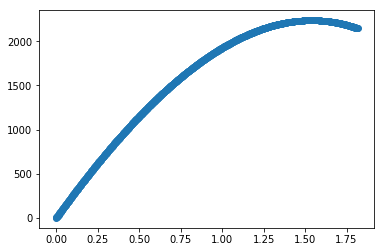

In [843]:
# Let LR range from 0 to 1000
LR = np.arange(0,1000)*(1/550)

# This list will be used to create many consumers identical to person1 but with varying Loan Rate
DummyConsumers = []

# Create the dummy consumers
for i in range(0,len(LR)):
    persontemp = []
    persontemp.append(LR[i])
    for j in range(1,len(logisticParams)):
        persontemp.append(person2[j])
    DummyConsumers.append(persontemp)

# Probability of default within 12 months of person1 as a function of loan rate
prob1 = lr12.predict_proba(DummyConsumers)[:,1]

# The OLS for this consumer
OLS = person2['Original Loan Size']

# The OT for this consumer
OT = person2['OriginalTermBucket']

# Value
Value = 3585.574940101065* LR + -39073.164730306715* LR**2 + 171.5044269061883* LR * OT + -38.59982148323444* LR**2 * OT

# The expected loss cannot be positive, value has to be less than OLS*LR
ExpectedLoss = prob1*(Value - OLS*LR)
map(lambda x: 0 if x > 0 else x,ExpectedLoss)

# The total value is then a function of default and the value given default
totValue = (1-prob1)*OLS*LR + ExpectedLoss

plt.scatter(x=LR,y=totValue)

As seen before, person2 is much less risky, as a result we are able to give a much larger Loan Rate (around 1.5) in order to maximise our returns due to this consumers lower default probability. For a particular Loan Rate, say 0.4, Person2 has Total Value near 1000 whereas Person1 has Total Value close to 800. So if we are looking for a return of 1000GBP, we would be able to offer Person1 a Loan Rate of around 0.7 while we would offer Person2 a Loan Rate of 0.45 and they would still be a more valuable consumer than Person1.

It must be said that less risky individuals are offered lower Loan Rates in general contrary to what we have just seen. The reason is that there exists a hypothetical function of customer satisfaction and industry competition. In the above example with person2, we cannot entice this consumer with a Loan Rate of 0.9, since the market can offer a better rate and still make a return. So in order to make use of the above model, we would need a penalty function dependent on customer satisfaction and a penalty function for administration work. This would also explain why the consumers were offered a lower rate than the optimum for the lender.

Once this has been incorporated in the form of customer churn, it may be possible to contact the customer to offer a better rate if this would off-set the penalty due to customer churn, i.e. we are offering a better rate in order to reduce the probability of losing this customer and therefore losing the return we would have made if we offered a slightly lower Loan Rate. 

It should also be noted that the model fit is not perfect. In fact, the residual plots are less than satisfactory. The qq-plot in particular show a not-so-normal fit. This may indicate another variable that needs to be included within the linear regression model or a possible transformation of the response variable.